In [1]:
import pandas as pd
import geopandas as gpd
import requests
import zipfile
import io
import os
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import root_mean_squared_error

# CART
from sklearn.tree import DecisionTreeRegressor

# random forest
from sklearn.ensemble import RandomForestRegressor

# feature importance
import rfpimp

# xgboost
import xgboost
from xgboost import XGBRegressor

from linearmodels.panel import PanelOLS
import statsmodels.api as sm

In [2]:
# Load ward shapefiles
#ward_boundaties = gpd.read_file("data/ward_boundaties.geojson")
ward_boundaties = gpd.read_file("https://raw.githubusercontent.com/YULI61/DSSS_PR/main/_data/ward_boundaties.geojson")


ward_boundaties = ward_boundaties[ward_boundaties['LAD24CD'].str.startswith('E09')].copy()
ward_boundaties['ward_area'] = ward_boundaties['geometry'].area / 1e6

ward = ward_boundaties[["WD24CD", "WD24NM", "LAD24CD", "geometry", "ward_area"]]

In [3]:
ward

,WD24CD,WD24NM,LAD24CD,geometry,ward_area
1104,E05009288,Aldersgate,E09000001,"POLYGON ((532248.702 181560.298, 532206.999 18...",0.098405
1105,E05009289,Aldgate,E09000001,"POLYGON ((533466.102 181405.602, 533617.704 18...",0.114784
1106,E05009290,Bassishaw,E09000001,"POLYGON ((532536.199 181632.598, 532653.197 18...",0.106979
1107,E05009291,Billingsgate,E09000001,"POLYGON ((533320.062 180540.376, 532961.374 18...",0.086042
1108,E05009292,Bishopsgate,E09000001,"POLYGON ((533404.869 182037.77, 533351.225 181...",0.254265
...,...,...,...,...,...
5011,E05014115,Streatham St Leonard's,E09000022,"POLYGON ((530286.651 172684.166, 530284.695 17...",1.462074
5012,E05014116,Streatham Wells,E09000022,"POLYGON ((530932.87 172130.459, 531050 172066....",0.953108
5013,E05014117,Vauxhall,E09000022,"POLYGON ((530736.649 178729.341, 530701.444 17...",0.684731
5014,E05014118,Waterloo & South Bank,E09000022,"POLYGON ((531338.544 180527.779, 531350.432 18...",1.186647


In [4]:
city_of_london_wards = ward[ward['LAD24CD'] == 'E09000001']

city_of_london_merged = city_of_london_wards.dissolve()

city_of_london_merged['WD24CD'] = 'E09000001'
city_of_london_merged['WD24NM'] = 'City of London'
city_of_london_merged['LAD24CD'] = 'E09000001'
city_of_london_merged['ward_area'] = city_of_london_wards['ward_area'].sum()  # 把所有面积加起来

city_of_london_merged = city_of_london_merged.reset_index(drop=True)

ward = ward[ward['LAD24CD'] != 'E09000001']
ward = pd.concat([ward, city_of_london_merged], ignore_index=True)

In [5]:
# Load data
crime = pd.read_csv("data/MPS Ward Level Crime (most recent 24 months).csv")

month_cols = crime.columns[5:]
crime["total_crime_count"] = crime[month_cols].sum(axis=1)

# Define property crime categories
property_major_categories = [
    "ARSON AND CRIMINAL DAMAGE",
    "BURGLARY",
    "ROBBERY",
    "THEFT"
]
property_minor_categories_vehicle = [
    "THEFT FROM A MOTOR VEHICLE",
    "THEFT OR TAKING OF A MOTOR VEHICLE"
]

# Create property crime flag
crime["is_property_crime"] = (
    (crime["MajorText"].isin(property_major_categories)) |
    ((crime["MajorText"] == "VEHICLE OFFENCES") & (crime["MinorText"].isin(property_minor_categories_vehicle)))
)

# Group by
crime_summary = crime.groupby('WardCode').agg(
    total_crimes=("total_crime_count", "sum"),
    property_crimes=("is_property_crime", lambda x: (x * crime.loc[x.index, "total_crime_count"]).sum()),
    WardName=("WardName", "first") 
).reset_index()

# Calculate property crime ratio
crime_summary["property_crime_ratio"] = crime_summary["property_crimes"] / crime_summary["total_crimes"]
crime_summary["non_property_crime_ratio"] = 1 - crime_summary["property_crime_ratio"]

In [6]:
# Merge crime summary with WARD shapefile
ward = pd.merge(ward, crime_summary,left_on='WD24CD', right_on='WardCode', how='left')

# Step 3: Calculate crime density (only where crime exists)
ward['crime_density'] = ward['total_crimes'] / ward['ward_area']

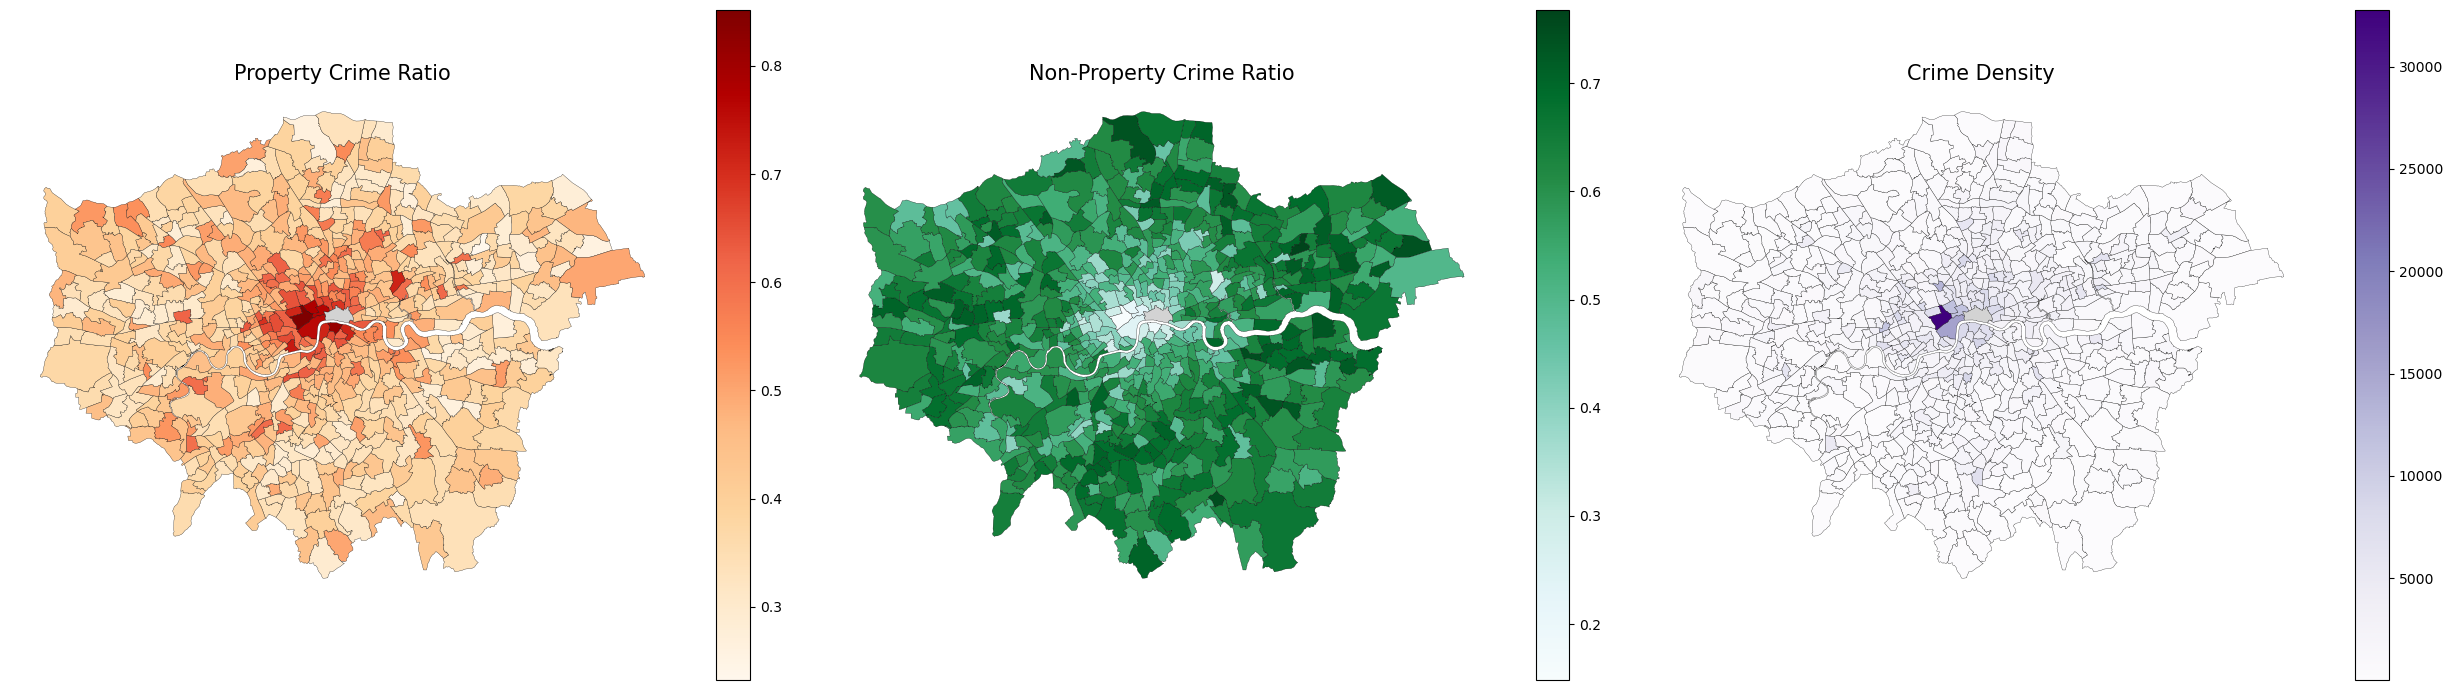

In [7]:
# Set up 1 row, 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(25, 7)) 

# Plot property crime ratio
ward.plot(
    column="property_crime_ratio", 
    cmap="OrRd", 
    legend=True,
    ax=axes[0],
    missing_kwds={"color": "lightgrey"},
    edgecolor="black",  
    linewidth=0.2      
)
axes[0].set_title("Property Crime Ratio", fontsize=15)
axes[0].axis("off")

# Plot non-property crime ratio
ward.plot(
    column="non_property_crime_ratio", 
    cmap="BuGn", 
    legend=True,
    ax=axes[1],
    missing_kwds={"color": "lightgrey"},
    edgecolor="black",  
    linewidth=0.2
)
axes[1].set_title("Non-Property Crime Ratio", fontsize=15)
axes[1].axis("off")

# Plot crime density
ward.plot(
    column="crime_density",    
    cmap="Purples", 
    legend=True,
    ax=axes[2],
    missing_kwds={"color": "lightgrey"},
    edgecolor="black",  
    linewidth=0.2
)
axes[2].set_title("Crime Density", fontsize=15)
axes[2].axis("off")

plt.tight_layout()
plt.show()


2. Built environment data

绿地密度（greenspace area / lsoa area）

交通可达性（transport area / lsoa area）

道路密度（road length / lsoa area）

建筑密度（building area / lsoa area）

In [8]:
# Load built environment datasets
#greenspace = gpd.read_file("data/OS_Open_Greenspace/data/GB_GreenspaceSite.shp")
#road = gpd.read_file("data/opmplc_essh_tq/OS_OpenMap_Local_TQ/data/TQ_Road.shp")
#building = gpd.read_file("data/opmplc_essh_tq/OS_OpenMap_Local_TQ/data/TQ_Building.shp")

zip_url = "zip://https://github.com/YULI61/DSSS_PR/raw/main/_data/BE_simplified.zip!"

#greenspace = gpd.read_file(f"{zip_url}/greenspace_simplified.geojson")
#road = gpd.read_file(f"{zip_url}/road_simplified.geojson")
#building = gpd.read_file(f"{zip_url}/building_simplified.geojson")

#url = "https://raw.githubusercontent.com/YULI61/DSSS_PR/main/_data/BE_simplified.zip"
#response = requests.get(url)

# Step 2: 解压到内存并从其中读取文件
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    with z.open("greenspace_simplified.geojson") as f:
        greenspace = gpd.read_file(f)

    with z.open("road_simplified.geojson") as f:
        road = gpd.read_file(f)

    with z.open("building_simplified.geojson") as f:
        building = gpd.read_file(f)

bus = pd.read_csv("data/Bus_Stops.csv")
bus = gpd.GeoDataFrame(
    bus,
    geometry=gpd.points_from_xy(bus['X'], bus['Y']),
    crs="EPSG:27700" 
)

RailwayStation = pd.read_csv("data/Overground_Stations.csv")
RailwayStation = gpd.GeoDataFrame(
    RailwayStation,
    geometry=gpd.points_from_xy(RailwayStation['X'], RailwayStation['Y']),
    crs="EPSG:27700" 
)

# Reproject all to LSOA CRS first
greenspace = greenspace.to_crs(ward.crs)
RailwayStation = RailwayStation.to_crs(ward.crs)
road = road.to_crs(ward.crs)
building = building.to_crs(ward.crs)
bus = bus.to_crs(ward.crs)

NameError: name 'response' is not defined

In [ ]:
# Spatial join
building_with_ward = gpd.sjoin(building, ward, how="inner", predicate="within")
road_with_ward = gpd.sjoin(road, ward, how="inner", predicate="within")
greenspace_with_ward = gpd.sjoin(greenspace, ward, how="inner", predicate="within")
railway_with_ward = gpd.sjoin(RailwayStation, ward, how="inner", predicate="within")
bus_with_ward = gpd.sjoin(bus, ward, how="inner", predicate="within")

# Groupby and aggregate
building_area = building_with_ward.groupby("WD24CD")["geometry"].apply(lambda x: x.area.sum())
road_length = road_with_ward.groupby("WD24CD")["geometry"].apply(lambda x: x.length.sum())
greenspace_area = greenspace_with_ward.groupby("WD24CD")["geometry"].apply(lambda x: x.area.sum())
railway_counts = railway_with_ward.groupby("WD24CD").size()
bus_counts = bus_with_ward.groupby("WD24CD").size()

# Merge back
ward["lsoa_area"] = ward.geometry.area
ward["building_area"] = ward["WD24CD"].map(building_area)
ward["road_length"] = ward["WD24CD"].map(road_length)
ward["greenspace_area"] = ward["WD24CD"].map(greenspace_area)
ward['bus_counts'] = ward['WD24CD'].map(bus_counts).fillna(0)
ward['railway_counts'] = ward['WD24CD'].map(railway_counts).fillna(0)
ward["public_transport_counts"] = ward["bus_counts"] + ward["railway_counts"]

ward = ward.fillna(0)

# Calculate density variables
ward["building_density"] = ward["building_area"] / ward["ward_area"]
ward["road_density"] = ward["road_length"] / ward["ward_area"]
ward["greenspace_density"] = ward["greenspace_area"] / ward["ward_area"]
ward["public_transport_density"] = ward["public_transport_counts"] / ward["ward_area"]

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Greenspace Density
ward.plot(column="greenspace_density", cmap="Greens", ax=axes[0,0], legend=True)
ward.boundary.plot(ax=axes[0,0], color="black", linewidth=0.1)
axes[0,0].set_title("Greenspace Density")

# Transport Accessibility 
ward.plot(column="public_transport_counts", cmap="Blues", ax=axes[0,1], legend=True)
ward.boundary.plot(ax=axes[0,1], color="black", linewidth=0.1)
axes[0,1].set_title("Transport Accessibility ")

# Building Density
ward.plot(column="building_density", cmap="Purples", ax=axes[1,0], legend=True)
ward.boundary.plot(ax=axes[1,0], color="black", linewidth=0.1)
axes[1,0].set_title("Building Density")

# Road Density
ward.plot(column="road_density", cmap="Reds", ax=axes[1,1], legend=True)
ward.boundary.plot(ax=axes[1,1], color="black", linewidth=0.1)
axes[1,1].set_title("Road Density")

# Turn off axis lines
for ax in axes.flat:
    ax.axis('off')

plt.tight_layout()
plt.show()

3. Social environment

In [ ]:
deprivation = pd.read_csv("data/Household deprivation.csv")  
age = pd.read_csv("data/Five year age bands.csv")  
usual_residents = pd.read_csv("data/2021_usual_residents.csv")  
ethnic = pd.read_csv("data/2021_ethnic_group.csv")

In [ ]:
#Merge age data
work_age_cols = age.columns[8:17]
age['working_age_population'] = age[work_age_cols].sum(axis=1)
age['working_age_ratio'] = age['working_age_population'] / age["All usual residents"]
age = age[['ward code', 'working_age_ratio']]

ward = pd.merge(ward, age, left_on='WD24CD', right_on='ward code', how='left')

ward = ward.drop(columns='ward code')

In [ ]:
#Merge gender data
usual_residents["male_ratio"] = usual_residents["Males"] / (usual_residents["All usual residents"])
usual_residents["population"] = usual_residents["All usual residents"] 

ward = ward.merge(
    usual_residents[["ward code", "population", "male_ratio"]],
    how="left", left_on="WD24CD", right_on="ward code"
)

ward["population_density"] = ward["population"] / (ward["ward_area"]) 

ward = ward.drop(columns=["ward code"])

In [ ]:
#Merge ethnicity data
ethnic["white_ratio"] = ethnic.iloc[:, 5:10].sum(axis=1) / ethnic.iloc[:, 4].astype(float)
ethnic["mixed_ratio"] = ethnic.iloc[:, 10:14].sum(axis=1) / ethnic.iloc[:, 4].astype(float)
ethnic["asian_ratio"] = ethnic.iloc[:, 14:19].sum(axis=1) / ethnic.iloc[:, 4].astype(float)
ethnic["black_ratio"] = ethnic.iloc[:, 19:23].sum(axis=1) / ethnic.iloc[:, 4].astype(float)

# Merge ethnicity ratios into ward
ward = ward.merge(
    ethnic[["ward code", "white_ratio", "mixed_ratio", "asian_ratio", "black_ratio"]],
    how="left",
    left_on="WD24CD",
    right_on="ward code"
)

ward = ward.drop(columns="ward code")

# Fill missing values if any
ward = ward.fillna(0)

In [ ]:
#Merge deprivation data
deprivation['average_deprivation'] = (
    (1 * deprivation['1 dimension']) +
    (2 * deprivation['2 dimensions']) +
    (3 * deprivation['3 dimensions']) +
    (4 * deprivation['4 dimensions'])
) / deprivation['All Households']

ward = ward.merge(
    deprivation[["ward code", "average_deprivation"]],
    how="left", left_on="WD24CD", right_on="ward code"
)

ward = ward.drop(columns='ward code')

In [ ]:
ward.columns

In [ ]:
crime_value = ward[['crime_density','property_crime_ratio','building_density',
       'road_density', 'greenspace_density', 'public_transport_density',
       'working_age_ratio', 'male_ratio', 'population_density',
       'white_ratio', 'mixed_ratio', 'asian_ratio', 'black_ratio',
       'average_deprivation']]

In [ ]:
crime_value.info()

In [ ]:
random_state_split = 100
train_x, test_x, train_y, test_y = train_test_split(crime_value.drop(['crime_density'], axis = 1), 
                                                    crime_value.crime_density, random_state=random_state_split)

print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

# check the index of train_x and train_y - they should be identical. The index indicates which rows from the original data.

print(train_x.index.identical(train_y.index))
print(test_x.index.identical(test_y.index))

In [ ]:
# Train a default CART model
cart_default = DecisionTreeRegressor(random_state=0)
cart_default.fit(train_x, train_y)

# Get the default tree depth
default_depth = cart_default.get_depth()
print(f"Default tree depth is: {default_depth}")

In [ ]:
# Define hyperparameter grid based on the observed depth
param_grid = {
    'max_depth': [5,10,15,20,25,30,35],
    'min_samples_split': [6,8,10,12,14]
}

# Perform Grid Search
randomState_dt = 10000
dt = DecisionTreeRegressor(random_state=randomState_dt)
clf = GridSearchCV(dt, param_grid, cv=5)
clf.fit(train_x, train_y)

# Print best parameters
print("Best parameters:", clf.best_params_)
print("Best score:", clf.best_score_)

In [ ]:
dt_final = DecisionTreeRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
dt_final.fit(train_x, train_y)

In [ ]:
print("Tree depth:{}".format(dt_final.get_depth()))
print("Number of leaves:{}".format(dt_final.get_n_leaves()))

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth': [5,10,15,20,25,30,35],
    'min_samples_split': [4,6,8,10,12,14]
}

randomState_dt = 10000
rf = RandomForestRegressor(random_state=randomState_dt)

# cv=5 by default, which means 5-fold cross-validation
clf = GridSearchCV(rf, hyperparameters)

clf.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (clf.best_params_)
print ("The best score is: ")
print (clf.best_score_)

In [ ]:
rf_final = RandomForestRegressor(max_depth=clf.best_params_['max_depth'], min_samples_split=clf.best_params_['min_samples_split'], random_state=randomState_dt)
rf_final.fit(train_x, train_y)

In [ ]:
# values of max_depth and min_samples_split
hyperparameters = {'max_depth':[10,20,30,40,50], 'n_estimators':[50,100,150,200,250]}

randomState_xgb = 125
xgb = XGBRegressor(random_state=randomState_xgb)

# cv=5 by default, which means 5-fold cross-validation
gscv_xgb = GridSearchCV(xgb, hyperparameters)

gscv_xgb.fit(train_x, train_y)

# we can query the best parameter value and its accuracy score
print ("The best parameter value is: ")
print (gscv_xgb.best_params_)
print ("The best score is: ")
print (gscv_xgb.best_score_)

In [ ]:
xgb_final = XGBRegressor(max_depth=gscv_xgb.best_params_['max_depth'], n_estimators=gscv_xgb.best_params_['n_estimators'], random_state=randomState_xgb)
xgb_final.fit(train_x, train_y)

In [ ]:
# CART
r2_train_cart = dt_final.score(train_x, train_y)
r2_test_cart = dt_final.score(test_x, test_y)
r2_diff_cart = r2_train_cart - r2_test_cart

# RF
r2_train_rf = rf_final.score(train_x, train_y)
r2_test_rf = rf_final.score(test_x, test_y)
r2_diff_rf = r2_train_rf - r2_test_rf

# XGB
r2_train_xgb = xgb_final.score(train_x, train_y)
r2_test_xgb = xgb_final.score(test_x, test_y)
r2_diff_xgb = r2_train_xgb - r2_test_xgb

results = pd.DataFrame({
    'R2_train_data': [r2_train_cart, r2_train_rf, r2_train_xgb],
    'R2_test_data': [r2_test_cart, r2_test_rf, r2_test_xgb],
    'R2_diff': [r2_diff_cart, r2_diff_rf, r2_diff_xgb]
}, index=['CART', 'RF', 'XGBoost'])

display(results)

In [ ]:
imp = rfpimp.importances(xgb_final, test_x, test_y) # permutation
print(imp)
viz = rfpimp.plot_importances(imp)
viz.view()

In [ ]:
# 1. Load crime data
crime = pd.read_csv("data/MPS Ward Level Crime (Historical).csv")
ward_lookup = ward_boundaties[["WD24CD", "LAD24CD"]]  # WD24CD = WardCode, LAD24CD = BoroughCode

# 3. Merge crime data with borough code
crime = crime.merge(ward_lookup, how="left", left_on="WardCode", right_on="WD24CD")

# 4. Filter needed month columns (e.g., 201004 to 202203)
month_cols = [col for col in crime.columns if col.isdigit()]
month_cols = [col for col in month_cols if 201004 <= int(col) <= 202203]

# 5. Reshape into long format
crime_long = crime.melt(id_vars=["LAD24CD"], value_vars=month_cols, var_name="Month", value_name="Crime_Count")

# 6. Convert month into proper datetime
crime_long["Month"] = pd.to_datetime(crime_long["Month"], format='%Y%m')

# 7. Create Fiscal Year
crime_long["Fiscal_Year"] = crime_long["Month"].apply(
    lambda x: f"{x.year}-{x.year+1}" if x.month >= 4 else f"{x.year-1}-{x.year}"
)

# 8. Group by borough and fiscal year
crime_fy = crime_long.groupby(["LAD24CD", "Fiscal_Year"])["Crime_Count"].sum().reset_index()

# 9. Pivot to wide table
crime_fy_wide = crime_fy.pivot(index="LAD24CD", columns="Fiscal_Year", values="Crime_Count").fillna(0).reset_index()

crime_fy_wide.head()

In [ ]:
# Load data and skip 1st and 3rd rows
housing = pd.read_csv("data/net-additional-dwellings-total-stock-borough.csv", skiprows=[0, 2])

# Rename LAD24CD
housing = housing.rename(columns={housing.columns[0]: "LAD24CD"})

# Keep only LAD24CD + years columns
cols_to_keep = ["LAD24CD"] + [col for col in housing.columns if "-" in col or "/" in col]
housing = housing[cols_to_keep]

# Fix fiscal year column names
new_columns = []
for col in housing.columns:
    if "-" in col or "/" in col:
        col = col.replace("/", "-")  # replace "/" with "-"
        start_year = col.split("-")[0]
        end_year = col.split("-")[1].zfill(2)
        full_year = f"{start_year}-20{end_year}"
        new_columns.append(full_year)
    else:
        new_columns.append(col)
housing.columns = new_columns

# Check
housing.head()

In [ ]:
# 1. Crime reshape
crime_long = crime_fy_wide.melt(
    id_vars="LAD24CD",
    var_name="fiscal_year",
    value_name="crime_count"
)

# 2. Housing reshape
housing_long = housing.melt(
    id_vars="LAD24CD",
    var_name="fiscal_year",
    value_name="new_dwellings"
)

# 3. Merge
merged = crime_long.merge(housing_long, on=["LAD24CD", "fiscal_year"], how="left")

merged = merged.dropna() 

In [ ]:
merged

In [ ]:
merged['new_dwellings'] = merged['new_dwellings'].str.replace(',', '').astype(float)
merged['crime_count'] = merged['crime_count'].astype(float)

merged['crime_count_diff'] = merged.groupby('LAD24CD')['crime_count'].diff()
merged = merged.dropna(subset=['crime_count_diff', 'new_dwellings'])

In [ ]:
palette = sns.color_palette("husl", n_colors=len(merged['LAD24CD'].unique()))

fig, ax1 = plt.subplots(figsize=(14, 7))

# crime_count_diff 用左轴
for i, borough in enumerate(merged['LAD24CD'].unique()):
    data = merged[merged['LAD24CD'] == borough].sort_values('fiscal_year')
    ax1.plot(data['fiscal_year'], data['crime_count_diff'], label=borough, color=palette[i], alpha=0.7)

ax1.set_ylabel('Crime Count Diff', color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xlabel('Fiscal Year')

# new_dwellings 用右轴
ax2 = ax1.twinx()
for i, borough in enumerate(merged['LAD24CD'].unique()):
    data = merged[merged['LAD24CD'] == borough].sort_values('fiscal_year')
    ax2.plot(data['fiscal_year'], data['new_dwellings'], linestyle='--', color=palette[i], alpha=0.4)

ax2.set_ylabel('New Dwellings', color='black')
ax2.tick_params(axis='y', labelcolor='black')


min_crime_diff_row = merged.loc[merged['crime_count_diff'].idxmin()]
max_dwellings_row = merged.loc[merged['new_dwellings'].idxmax()]

borough_min_crime = min_crime_diff_row['LAD24CD']
borough_max_dwell = max_dwellings_row['LAD24CD']

ax1.text(min_crime_diff_row['fiscal_year'], min_crime_diff_row['crime_count_diff'],
         f"{borough_min_crime}", color='darkred', fontsize=10)

ax2.text(max_dwellings_row['fiscal_year'], max_dwellings_row['new_dwellings'],
         f"{borough_max_dwell}", color='darkblue', fontsize=10)


# 图例和样式
plt.title('Trends of Crime Count Diff and New Dwellings by Borough')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
merged = merged.copy()
merged['fiscal_year'] = merged['fiscal_year'].astype(str) 
merged['fiscal_year_num'] = merged['fiscal_year'].str[:4].astype(int)
merged = merged.set_index(['LAD24CD', 'fiscal_year_num'])

In [ ]:
# 2. Run Fixed Effects Regression using formula
model = PanelOLS.from_formula('crime_count_diff ~ 1 + new_dwellings + EntityEffects', data=merged).fit()

# 3. Print result
print(model)

In [ ]:
model = PanelOLS.from_formula(
    'crime_count_diff ~ 1 + new_dwellings + EntityEffects + TimeEffects',
    data=merged
).fit()
print(model)